# 6.2 오토인코더로 이미지의 특징 추출하기

6.2.1 오토인코더 구현

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torchvision import datasets,transforms

In [2]:
# 오토인코더가 생성하는 이미지를 관찰해야 하므로 이미지 출력을 돕는 맷플롯립 모듈과 행렬 변환 도와주는 넘파이를 함께 import

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Axes3D 모듈은 맷플롯립에서 3차원 플롯을 그리는 용도
from matplotlib import cm  # cm 모듈은 데이터 포인트에 색상을 입히는데 사용됨
import numpy as np

In [3]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("using device: ", DEVICE)

using device:  cpu


In [5]:
#Fashion MNIST 데이터셋 로딩
# 이번 예제에서는 간단하게 학습 데이터셋만 사용

trainset = datasets.FashionMNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers =2)

In [6]:
# 오토인코더 모듈 정의

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28,128), nn.ReLU(),nn.Linear(128,64), nn.ReLU(),nn.Linear(64,12), nn.ReLU(),
                                    nn.Linear(12,3),)  # 인코더의 출력값이 잠재변수
        # 디코더는 3차원의 잠재변수를 받아 다시 784(28*28)차원의 이미지로 복원
        self.decoder = nn.Sequential(nn.Linear(3,12), nn.ReLU(),nn.Linear(12,64), nn.ReLU(),nn.Linear(64,128), nn.ReLU(),
                                    nn.Linear(128,28*28),nn.Sigmoid())  # 인코더와 차이점은 시그모이드 함수가 더해진 것
        
    def forward(self,x):
        #인코더는 잠재 변수인 encoded를 만들고 디코더는 복원 이미지인 decoded를 만듦
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [7]:
# 모델과 최적화 함수 객체 불러오기

autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr = 0.005)  # 최적화 함수는 Adam(SGD의 변형 함수)
criterion = nn.MSELoss()  #디코더에서 나온 값과 원본의 차이 즉, 오차를 계산하기 위해서 평균제곱오차(오차함수)사용
# 한 에폭이 완료될 때마다 복원이 어떻게 되는지 눈으로 관찰하기 위해
# 학습 데이터셋에 잇는 5개의 이미지를 가져와 모델에 바로 넣을 수 있도록 간단한 전처리함
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255  # 255로 나누는 이유는 픽셀의 값이 0~255이므로 우리가 만드는 모델이 인식하는 0~1값으로 만들기 위함

[epoch 1]


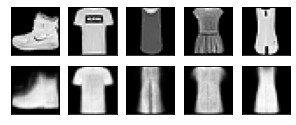

[epoch 2]


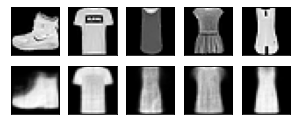

[epoch 3]


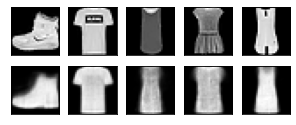

[epoch 4]


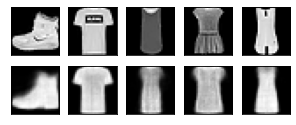

[epoch 5]


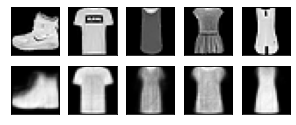

[epoch 6]


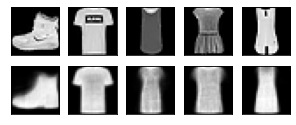

[epoch 7]


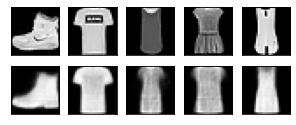

[epoch 8]


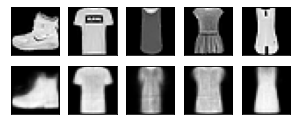

[epoch 9]


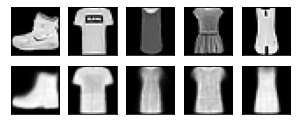

[epoch 10]


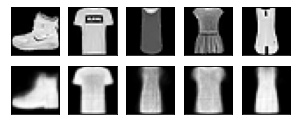

In [16]:
# 학습하는 함수

def train(autoencoder,train_loader):
    autoencoder.train()
    for step, (x,label) in enumerate(train_loader):
        # 주목할 점은 입력인 x와 대상 레이블인 y모두 원본 이미지 x라는 것
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)  # 데이터도 .to(DEVICE)하니까 label도 하는거..?
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded,y)  # decoded에서 y(원본 이미지)를 빼고 제곱한 값의 평균을 구해 손실(오차)를 구함
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 학습을 진행하면서 그 과정을 시각화하기

for epoch in range(1,EPOCH+1):
    train(autoencoder, train_loader)
    # 앞서 시각화를 위해 남겨둔 5개의 이미지를 한 에폭만큼 학습을 마친 모델에 넣어 복원 이미지를 만듦
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)  # 질문. test_x말고 view_data넣으면 왜 안되는지? cpu이면 굳이 필요없는데 gpu일 경우에는 필요해서..?
    # f는 에폭이 10이면 10개의 액자 전체를 하나로 보는걸 의미, a는 에폭 하나에 있는 액자들을 의미? 
    f, a = plt.subplots(2,5,figsize=(5,2))  # plt.subplots으로 일종의 액자를 만듦. 액자는 2줄 5칸으로 구성
    print("[epoch {}]".format(epoch))  
    
    # view_data에 저장된 원본 이미지들을 차례로 액자에 담아야함
    #맷플롯립은 파이토치 텐서를 지원하지 않아서 넘파이 행렬로 변환해야함
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img,cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
    # 변환한 이미지도 순서대로 액자의 두 번째 줄에 넣어줌
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i],(28,28))
        a[1][i].imshow(img,cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    
    plt.show()

6.2.2 잠재 변수 들여다보기

In [17]:
# 잠재 변수 들여다보기 위해서 학습된 모델에 데이터셋 넣고 돌려 잠재 변수를 시각화 해본 것
# 학습 데이터셋으로부터 원본 이미지 200개를 준비하고 미리 설정해준 device로 보낸 뒤 autoencoder의 encoded값을 다시 cpu로 가져옴

view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

In [19]:
print(encoded_data)

tensor([[-2.0685e+00,  6.5109e+00, -5.5075e+00],
        [-6.9006e+00, -1.8946e+00,  1.2370e-01],
        [-2.8202e+00, -5.9459e-01,  1.9628e+00],
        [-3.8997e+00, -1.4401e+00,  1.4893e+00],
        [-6.2607e+00, -1.3098e+00,  3.8192e+00],
        [-6.5489e+00,  4.7366e+00, -1.5324e+00],
        [-6.7084e-01, -2.1610e+00, -3.4103e+00],
        [-9.4492e+00,  4.5308e+00, -3.3069e+00],
        [ 2.7989e-01,  1.9013e+00, -7.0195e-02],
        [ 4.3760e-01,  3.6169e+00, -1.2039e+00],
        [-5.9647e+00, -1.5687e+00,  1.4253e+00],
        [ 2.0183e-02,  1.1721e+01, -4.5818e-01],
        [-1.4065e+00,  6.7932e-01, -2.6074e+00],
        [-6.1902e-01, -5.2763e-01, -1.8924e+00],
        [-1.5878e+00, -3.0634e+00, -1.6130e+00],
        [-8.0528e-01,  4.1979e+00, -5.7501e+00],
        [-4.5348e+00, -2.6700e+00,  2.2944e+00],
        [-6.6445e+00, -1.5380e+00,  1.8648e+00],
        [-5.7546e+00,  5.5529e+00, -1.9771e+00],
        [-2.0559e+00,  2.2059e+00,  5.2840e-01],
        [-6.5996e+00

In [18]:
# 각 잠재 변수에 레이블을 붙이고자 딕셔너리를 준비

CLASSES = { 0: 'T-shirt/top' , 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 
           6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle boot'}

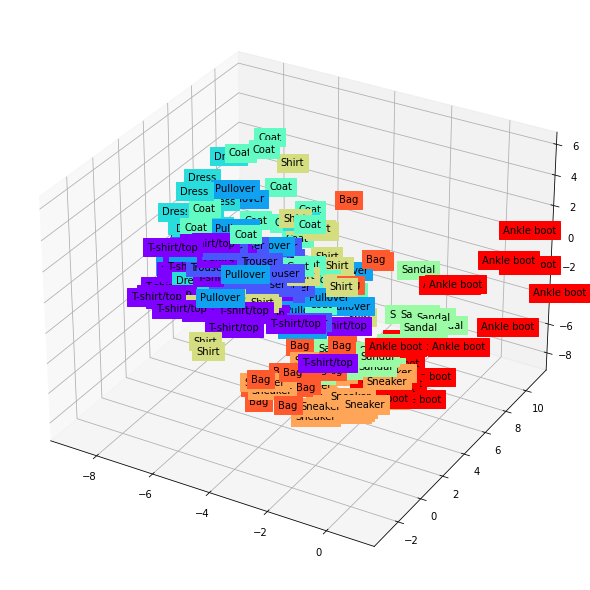

In [30]:
fig = plt.figure(figsize = (10,8))
ax = Axes3D(fig)  # 3차원의 액자 만듦

# 잠재변수의 각 차원을 따로 추출하여 넘파이 행렬로 변환
X = encoded_data.data[:, 0].numpy()  # 마지막 인덱스의 0번째가 뭘 의미하는지 질문!
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

for x,y,z,s in zip(X,Y,Z,labels):  #zip함수는 같은 길이의 행렬들을 모아 순서대로 묶어줌
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name, backgroundcolor=color)

# 모든 데이터가 한눈에 들어올 수 있게 액자 안의 x,y,z 최솟값과 최댓값을 지정
ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(),Y.max())
ax.set_zlim(Z.min(),Z.max())
plt.show()

# 6.3 오토인코더로 망가진 이미지 복원하기

6.3.1 잡음 제거 오토인코더 구현

In [34]:
# 학습 시 모델에 들어갈 입력에 add_noise 함수를 더해 이미지에 무작위 잡음을 더함

def add_noise(img):
    noise = torch.randn(img.size()) *0.2  # 무작위 잡음은 torch.randn함수로 만들며 이미지와 같은 크기의 잡음을 만듦
    noisy_img = img + noise
    return noisy_img

In [37]:
def train(autoencoder,train_loader):
    autoencoder.train()
    avg_loss = 0  # 평균 오찻값 
    for step, (x, label) in enumerate(train_loader):
        noisy_x = add_noise(x)  # 입력에 노이즈 추가
        noisy_x = noisy_x.view(-1,28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded,decoded = autoencoder(noisy_x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss = avg_loss + loss.item() 
        return avg_loss / len(train_loader)  # 반복마다 각 배치의 오찻값을 더한 후 마지막에 반복 횟수만큼 나누어 평균 구함

In [38]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[epoch{}] loss{}".format(epoch,loss))

[epoch1] loss2.468984200756179e-05
[epoch2] loss2.5086676769419267e-05
[epoch3] loss2.382693689133821e-05
[epoch4] loss2.2320464046906305e-05
[epoch5] loss2.7436081931662202e-05
[epoch6] loss2.4427771012284862e-05
[epoch7] loss2.4707406076159812e-05
[epoch8] loss2.3132090820178294e-05
[epoch9] loss2.4405794579591323e-05
[epoch10] loss2.385396510362625e-05


6.3.2 잡음 제거 시각화하기

In [39]:
# 모델이 본 적 없는 테스트 이미지를 활용해 검증하기
testset = datasets.FashionMNIST(root = './data', train = False, download = True, transform = transforms.ToTensor())

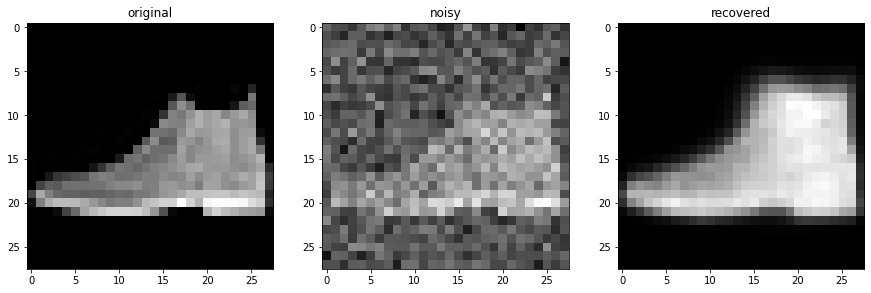

In [41]:
# 테스트셋에서 0번째 이미지 한장을 가져와 모델 입력으로 사용할 수 있게 차원과 값의 범위 조절
    
sample_data = testset.data[0].view(-1,28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)
f,a = plt.subplots(1,3,figsize=(15,15))
# 시각화를 위해 넘파이 행렬로 바꿔주기
original_img = np.reshape(original_x.to("cpu").data.numpy(),(28,28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(),(28,28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(),(28,28))

# 원본사진
a[0].set_title("original")
a[0].imshow(original_img,cmap='gray')
# 오염된 사진
a[1].set_title("noisy")
a[1].imshow(noisy_img,cmap='gray')
# 복원된 사진
a[2].set_title("recovered")
a[2].imshow(recovered_img,cmap='gray')